In [1]:
from huggingface_hub import login

with open('key.txt', 'r') as file:
    key = file.readline().strip()

login(token=key)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [2]:
from transformers import set_seed

SEED = 10107
set_seed(SEED)

MODEL = "deepseek-ai/deepseek-coder-6.7b-instruct"
DATASET = "google/code_x_glue_ct_code_to_text"

2024-08-18 15:18:43.009413: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 15:18:43.009480: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 15:18:43.010626: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-18 15:18:43.017009: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-18 15:18:43.727129: W tensorflow/compiler/tf2

In [3]:
#This set of utilities function and classes was imported 
#from https://github.com/deepseek-ai/DeepSeek-Coder/blob/main/finetune/finetune_deepseekcoder.py

import transformers
import torch
import copy
from dataclasses import dataclass, field
from typing import Optional, Dict, Sequence

IGNORE_INDEX = -100
EOT_TOKEN = "<|EOT|>"

def build_instruction_prompt(instruction: str):
    return '''
You are an AI programming assistant, utilizing the DeepSeek Coder model, developed by DeepSeek Company, and you only answer questions related to computer science. For politically sensitive questions, security and privacy issues, and other non-computer science questions, you will refuse to answer.
### Instruction:
{}
### Response:
'''.format(instruction.strip()).lstrip()

def _tokenize_fn(strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer) -> Dict:
    """Tokenize a list of strings."""
    tokenized_list = [
        tokenizer(
            text,
            return_tensors="pt",
            padding="longest",
            max_length=tokenizer.model_max_length,
            truncation=True,
        )
        for text in strings
    ]

    input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
    input_ids_lens = labels_lens = [
        tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list
    ]

    return dict(
        input_ids=input_ids,
        labels=labels,
        input_ids_lens=input_ids_lens,
        labels_lens=labels_lens,
    )


def preprocess(
    sources: Sequence[str],
    targets: Sequence[str],
    tokenizer: transformers.PreTrainedTokenizer,
) -> Dict:
    """Preprocess the data by tokenizing."""
    examples = [s + t for s, t in zip(sources, targets)]
    examples_tokenized, sources_tokenized = [_tokenize_fn(strings, tokenizer) for strings in (examples, sources)]
    input_ids = examples_tokenized["input_ids"]

    labels = copy.deepcopy(input_ids)
    for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
        label[:source_len] = IGNORE_INDEX
    return dict(input_ids=input_ids, labels=labels)

@dataclass
class DataCollatorForSupervisedDataset(object):
    """Collate examples for supervised fine-tuning."""
    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = [torch.tensor(x) for x in input_ids]
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = [torch.tensor(x) for x in labels]
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=IGNORE_INDEX)
        
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

def train_tokenize_function(examples, tokenizer):
    sources = [
        build_instruction_prompt(instruction)
        for instruction in examples['instruction']
    ]
    targets = [f"{output}\n{EOT_TOKEN}" for output in examples['output']]
    data_dict = preprocess(sources, targets, tokenizer)
    return data_dict


In [4]:
#This set of utilities function and classes was imported 
#from https://github.com/bigcode-project/bigcode-evaluation-harness/blob/main/bigcode_eval/tasks/codexglue_code_to_text.py

import re

TRIPLE_QUOTE = '"""'
SINGLE_TRIPLE_QUOTE = "'''"
SUFFIX_PROMPT = '\n""" The goal of this function is to:\n'

def standardize_docstring_prompt(prefix):
    """Strips any existing docstring delimiters from the prompt prefix
    and adds our own delimiter (triple quote) and whitespace.
    Note an edge cases being handled here:
    - codexglue docstring text sometimes contains the docstring delimiters, inconsistently

    source: InCoder evaluation code https://github.com/dpfried/lm-evaluation-harness/
    """

    for delim in [TRIPLE_QUOTE, SINGLE_TRIPLE_QUOTE]:
        if delim in prefix:
            prefix = prefix[: prefix.index(delim)]
            break

    single_single_quote_with_trailing_spaces = re.compile(r'[^\'"][\']\s*$')
    if single_single_quote_with_trailing_spaces.search(prefix):
        prefix = prefix[
            : single_single_quote_with_trailing_spaces.search(prefix).start()
        ]

    single_double_quote_with_trailing_spaces = re.compile(r'[^\'"]["]\s*$')
    if single_double_quote_with_trailing_spaces.search(prefix):
        prefix = prefix[
            : single_double_quote_with_trailing_spaces.search(prefix).start()
        ]

    prefix += TRIPLE_QUOTE
    return prefix

def remove_docstring(doc):
    """Generate prompts for Code to text benchmark (documentation generation)
    Prompt = full function body (withoout the docstring) + '\n[Delimiter] The goal of this function is to:\n'
    where delimiter is  \""" for python, =begin for ruby and /* for the rest (see SUFFIX_PROMPT).
    :param doc: dict[str: str])
    """
    code = doc["code"]
    text = doc["docstring"]
    prompt_prefix = code[: code.index(text)]
    prompt_prefix = standardize_docstring_prompt(prompt_prefix)
    prompt_suffix = code[code.index(text) + len(text) :]
    prompt_suffix = prompt_suffix.replace(TRIPLE_QUOTE, "")
    prompt_suffix = prompt_suffix.replace(SINGLE_TRIPLE_QUOTE, "")

    prompt_prefix = prompt_prefix.strip().removesuffix(TRIPLE_QUOTE)
    prompt_prefix = prompt_prefix.strip().removesuffix(SINGLE_TRIPLE_QUOTE)
    prompt = prompt_prefix + prompt_suffix + SUFFIX_PROMPT
    return prompt

In [5]:
from datasets import load_dataset
import torch
from tqdm import tqdm
import random

dataset = load_dataset(
    DATASET,
    'python',
    split="train",
)
print(dataset)

NB_SAMPLES = 15000

dataset = dataset.shuffle(seed=SEED)
dataset = dataset.select(range(NB_SAMPLES))

cleaned_code = [
    remove_docstring(sample) for sample in dataset
]

column_names = dataset.column_names
column_names.remove("docstring")
    
dataset = dataset.rename_column("docstring", "output")
dataset = dataset.remove_columns(column_names)
dataset = dataset.add_column('instruction', cleaned_code)
print(dataset)

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


Dataset({
    features: ['id', 'repo', 'path', 'func_name', 'original_string', 'language', 'code', 'code_tokens', 'docstring', 'docstring_tokens', 'sha', 'url'],
    num_rows: 251820
})
Dataset({
    features: ['output', 'instruction'],
    num_rows: 15000
})


/usr/local/lib/python3.11/dist-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by promote_options='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)


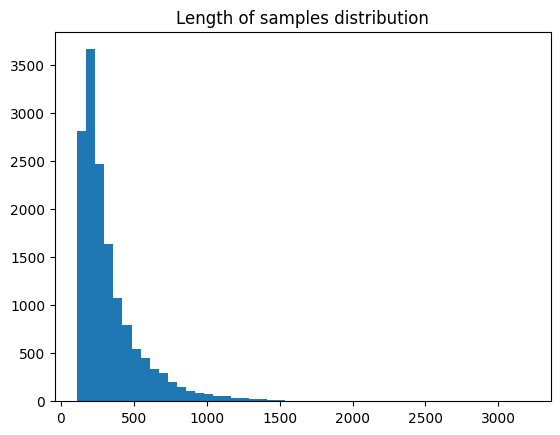

Number of samples to remove:  318
Dataset({
    features: ['input_ids', 'labels'],
    num_rows: 14682
})


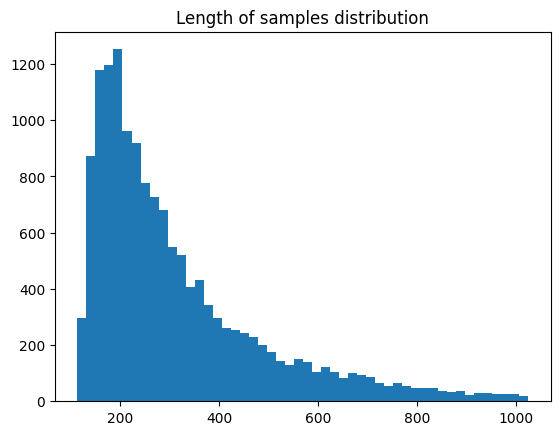

Dataset({
    features: ['input_ids', 'labels'],
    num_rows: 11745
})
Sample 4 of the training set: [32013, 2042, 417, 274, 20926, 14244, 20391, 11, 26696, 254, 20676, 8041, 74, 339, 8589, 2008, 11, 6908, 457, 20676, 8041, 74, 7958, 11, 285, 340, 885, 3495, 4301, 4512, 276, 4531, 8214, 13, 1487, 4636, 2223, 13143, 4301, 11, 5411, 285, 13936, 4447, 11, 285, 746, 2159, 12, 13517, 250, 8214, 4301, 11, 340, 540, 20857, 276, 3495, 13, 185, 13518, 3649, 3475, 25, 185, 1551, 12054, 7, 1180, 11, 3447, 62, 9523, 1772, 185, 294, 185, 436, 3579, 405, 3270, 2933, 4581, 13, 3154, 62, 22052, 7, 1180, 11, 3447, 62, 9523, 8, 185, 436, 967, 15224, 12636, 7, 4008, 8, 185, 23984, 428, 6206, 280, 437, 1155, 317, 276, 25, 185, 13518, 21289, 25, 185, 4317, 81, 1804, 4814, 365, 756, 3029, 473, 7122, 15224, 12636, 285, 7579, 245, 756, 15224, 12636, 2148, 13, 185, 185, 436, 1191, 2280, 3447, 62, 9523, 25, 15224, 4581, 365, 4814, 276, 12054, 254, 1642, 3029, 13, 185, 185, 436, 1191, 2125, 25, 245, 756, 15224,

In [6]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

tokenizer = AutoTokenizer.from_pretrained(
    MODEL,
    trust_remote_code=True,
    padding_side="right",
    use_fast=True
)

tokenized_dataset = dataset.map(
    train_tokenize_function,
    batched=True,
    batch_size = 1000,
    remove_columns=dataset.column_names,
    fn_kwargs={ "tokenizer": tokenizer }
)

sequence_length = []
for seq in tokenized_dataset['input_ids']:
    sequence_length.append(len(seq))

plt.figure()
plt.hist(sequence_length, bins=50)
plt.title("Length of samples distribution")
plt.show()

long_sequences_indices = [i for i, example in enumerate(tokenized_dataset) if len(example['input_ids']) > 1024]
print('Number of samples to remove: ', len(long_sequences_indices))

filtered_tokenized_dataset = tokenized_dataset.filter(lambda example, idx: idx not in long_sequences_indices, with_indices=True)
print(filtered_tokenized_dataset)

sequence_length = []
for seq in filtered_tokenized_dataset['input_ids']:
    sequence_length.append(len(seq))

plt.figure()
plt.hist(sequence_length, bins=50)
plt.title("Length of samples distribution")
plt.show()

split_dataset = filtered_tokenized_dataset.train_test_split(test_size=0.2)
train_data = split_dataset['train']
valid_data = split_dataset['test']

print(train_data)
index=4
print(f"Sample {index} of the training set: {train_data[index]['input_ids']}, {train_data[index]['labels']}.")
print(f"Sample {index} of the training set: {tokenizer.decode(list(train_data[index]['input_ids']))}.")

data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)
data_module = dict(train_dataset=train_data, eval_dataset=valid_data, data_collator=data_collator)

In [7]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from peft.tuners.lora import LoraLayer
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=getattr(torch, "bfloat16"),
    bnb_4bit_use_double_quant=True,
)

device_map = {"": 0}

model = AutoModelForCausalLM.from_pretrained(
    MODEL,
    load_in_8bit=False,
    quantization_config=bnb_config,
    device_map=device_map,
    use_cache=False,
    trust_remote_code=True,
)

print(model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaLinearScalingRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
  

In [8]:
import bitsandbytes as bnb

def find_all_linear_names(model, bit4=True, bit8=True):
    LinearModule = torch.nn.Linear
    if bit4:
        LinearModule = bnb.nn.Linear4bit
    if bit8:
        LinearModule = bnb.nn.Linear8bitLt
        
    module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, LinearModule):
            if "lm_head" in module_names:
                continue
            names = name.split(".")
            module_names.add(names[0] if len(names) == 1 else names[-1])
    
    return list(module_names)

target_modules = find_all_linear_names(model, bit4=True, bit8=False)
print(target_modules)

model = prepare_model_for_kbit_training(model)

peft_config = LoraConfig(
    lora_alpha=8,
    lora_dropout=0.05,
    r=8,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=target_modules,
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()
print(model)

['o_proj', 'gate_proj', 'q_proj', 'v_proj', 'up_proj', 'down_proj', 'k_proj']
trainable params: 19,988,480 || all params: 6,760,501,248 || trainable%: 0.2956656506189288
PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear4bit(
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (base_lay

In [9]:
# Set up wandb
import wandb
import os
import torch
import torch.nn.functional as F

wandb.login(key="22943c48738b2f0aa5a6b37af531509b75a16960")

# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     loss = F.cross_entropy(logits, labels).item()
#     return {"loss": loss}

# def preprocess_logits_for_metrics(logits, labels):
#     return logits

os.environ["WANDB_PROJECT"]="llm-finetune"
os.environ["WANDB_LOG_MODEL"]="true"
os.environ["WANDB_WATCH"]="false"

wandb: Currently logged in as: samueld. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [10]:
from transformers import Trainer, TrainingArguments

MAX_EPOCHS = 8
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 0.01
WARMUP_STEPS = 400
LOG_FREQ = 10
BATCH_SIZE = 2048
OUTPUT_DIR = "deepseek6.7-summarize-coder"
SCHEDULER = "cosine"

training_args = TrainingArguments(
    output_dir=f"Sam137/{OUTPUT_DIR}",
    overwrite_output_dir=True,
    report_to = "wandb",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=MAX_EPOCHS,
    logging_steps=LOG_FREQ,
    adam_beta1 = 0.9,
    adam_beta2 = 0.95,
    lr_scheduler_type=SCHEDULER,
    warmup_steps=WARMUP_STEPS,
    gradient_checkpointing=True,
    bf16=True,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    push_to_hub=True,
    auto_find_batch_size=True
)

trainer = Trainer(model=model, args=training_args, **data_module)

print("Training...")
trainer.train()

Training...


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f490c420490>> (for post_run_cell), with arguments args (<ExecutionResult object at 7f490c3c8110, execution_count=10 error_before_exec=None error_in_exec= info=<ExecutionInfo object at 7f4ab0644810, raw_cell="from transformers import Trainer, TrainingArgument.." store_history=True silent=False shell_futures=True cell_id=c4f7bab5-2bae-4185-bb1a-589697f59360> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [11]:
wandb.finish()

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f490c420490>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7f48f55eb0d0, raw_cell="wandb.finish()" store_history=True silent=False shell_futures=True cell_id=8e9cc364-23af-45b0-8b8a-f3a7e93a073b>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

train/epoch,▄▇▄▇▂▃▅▇▁▂▃▃▄▅▆▆▇█▁▂▂▂▃▃▄▄▄▅▅▆▆▆▇▇██▁▁▁▂
train/global_step,▁▁▁▂▁▂▂▂▁▁▂▂▃▃▃▄▄▅▁▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇██▁▂▂▂
train/learning_rate,▄▇▆█▄███▁▇████████▆█████████████████▄███
train/loss,█▇▇▇▆▇▇▆▅▆▇▅▆▇▇▆▆▇▅▄▄▅▄▅▅▅▃▅▆▆▅▆▆█▇▇▅▃▃▁
train/epoch,0.1
train/global_step,1230
train/learning_rate,0.0002
train/loss,0.6589
